In [1]:
import networkx as nx
import numpy as np
import sympy
import cirq
# TensorFlow
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
# TensorFlow Quantum
import tensorflow_quantum as tfq
from tensorflow_quantum.python.layers import Expectation

import matplotlib.pyplot as plt
%matplotlib inline

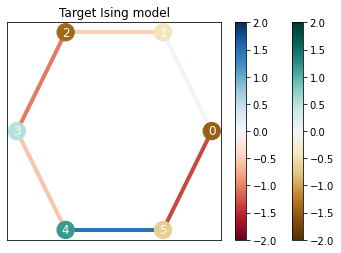

((0, 1), 0.0684219766242915) ((0, 5), -1.3281330415939832) ((1, 2), -0.4759481828751495) ((2, 3), -1.0423294015086495) ((3, 4), -0.5625653467895169) ((4, 5), 1.4748785348094264)
(0, -1.476920993990063) (1, -0.4517340842341979) (2, -1.410464984467898) (3, 0.5060585363559404) (4, 1.1773255714161315) (5, -0.6588018927365509)


In [2]:
# Define the number of qubits of our target quantum system.
N = 6
G = nx.cycle_graph(N)
weights = [4*(np.random.random()-0.5) for _ in G.edges]
biases = [4*(np.random.random()-0.5) for _ in G.nodes]

def draw(graph, pos, weights, biases, title):
    label = {i:'{}'.format(i) for i in graph.nodes}
    edge_options = {
        "edge_color": weights,
        "width": 4,
        "edge_cmap": plt.cm.RdBu,
        "edge_vmin" : -2,
        "edge_vmax" : 2,
    }
    node_options = {
        "node_color": biases,
        "cmap": plt.cm.BrBG,
        "vmin" : -2,
        "vmax" : 2,
    }
    nx.draw_networkx_labels(graph, pos, label, font_color="w")
    nodes = nx.draw_networkx_nodes(graph, pos, **node_options)
    edges = nx.draw_networkx_edges(graph, pos, **edge_options)
    edges.set_cmap(plt.cm.RdBu)
    edges.set_clim(-2, 2)

    plt.title(title)
    plt.colorbar(nodes)
    plt.colorbar(edges)
    plt.show()


pos = nx.circular_layout(G)
draw(G, pos, weights, biases, 'Target Ising model')
print(*zip(G.edges, weights))
print(*zip(G.nodes, biases))

In [3]:
def Hamiltonian(graph, weights, biases, qubits):
    H_cost = [w * cirq.Z(qubits[i]) * cirq.Z(qubits[j]) \
            for (i, j), w in zip(graph.edges, weights)]
    H_cost += [b * cirq.Z(qubits[v]) for v, b in enumerate(biases)]
    H_mixer = [cirq.X(q) for q in qubits]
    return H_cost, H_mixer

qubits = cirq.GridQubit.rect(1, N)
true_H_cost, true_H_mixer = Hamiltonian(G, weights, biases, qubits) 
for cost in true_H_cost:
    print(cost)
for mixer in true_H_mixer:
    print(mixer)


(0.0684219766242915+0j)*Z((0, 0))*Z((0, 1))
(-1.3281330415939832+0j)*Z((0, 0))*Z((0, 5))
(-0.4759481828751495+0j)*Z((0, 1))*Z((0, 2))
(-1.0423294015086495+0j)*Z((0, 2))*Z((0, 3))
(-0.5625653467895169+0j)*Z((0, 3))*Z((0, 4))
(1.4748785348094264+0j)*Z((0, 4))*Z((0, 5))
(-1.476920993990063+0j)*Z((0, 0))
(-0.4517340842341979+0j)*Z((0, 1))
(-1.410464984467898+0j)*Z((0, 2))
(0.5060585363559404+0j)*Z((0, 3))
(1.1773255714161315+0j)*Z((0, 4))
(-0.6588018927365509+0j)*Z((0, 5))
X((0, 0))
X((0, 1))
X((0, 2))
X((0, 3))
X((0, 4))
X((0, 5))


In [4]:


class VQE:
    """Variational Quantum Eigensolver"""
    def __init__(self, qubits):
        self.qubits = qubits
        # Parameters
        t_x = ['t_x{}'.format(i) for i, _ in enumerate(qubits)]
        t_z = ['t_z{}'.format(i) for i, _ in enumerate(qubits)]
        self.symbols = t_x + t_z
        # Parameterized quantum gates without Qubits
        gates = []
        gates.append([cirq.XPowGate(exponent=sympy.Symbol(x)) for x in t_x])
        gates.append([cirq.ZPowGate(exponent=sympy.Symbol(z)) for z in t_z])
        self._gates = gates
        self.circuit = self.get_state(qubits)

    def get_state(self, qubits, params=None):
        """Outputs quantum data with given qubits."""
        circuit = cirq.Circuit(
            [g(i) for gates in self._gates for i, g in zip(qubits, gates)])
        if params is None:
            return circuit
        resolver = {k: v for k, v in zip(self.symbols, params)}
        return cirq.resolve_parameters(circuit, resolver)

vqe = VQE(qubits)
print(vqe.circuit)



(0, 0): ───X^t_x0───Z^t_z0───

(0, 1): ───X^t_x1───Z^t_z1───

(0, 2): ───X^t_x2───Z^t_z2───

(0, 3): ───X^t_x3───Z^t_z3───

(0, 4): ───X^t_x4───Z^t_z4───

(0, 5): ───X^t_x5───Z^t_z5───


In [13]:
vqe.symbols

['t_x0',
 't_x1',
 't_x2',
 't_x3',
 't_x4',
 't_x5',
 't_z0',
 't_z1',
 't_z2',
 't_z3',
 't_z4',
 't_z5']

In [5]:
def vqe_keras_model(vqe, H_target):
    # Construct measurement layers.
    circuit_input = Input(shape=(), dtype=tf.string)
    output = Expectation()(
            circuit_input,
            symbol_names=vqe.symbols,
            operators=tfq.convert_to_tensor([H_target]),
            initializer=tf.keras.initializers.RandomNormal())
    # Each term in H_target is calculated respectively.
    # Here, we sum them up to get the final <H>.
    output = tf.math.reduce_sum(output, axis=-1, keepdims=True)

    # Model compile
    model = Model(inputs=circuit_input, outputs=output)
    adam = Adam(learning_rate=0.05)
    model.compile(optimizer=adam, loss='mse')
    return model

H_target = true_H_cost + true_H_mixer
model = vqe_keras_model(vqe, H_target)

In [11]:
type(H_target[0])

cirq.ops.pauli_string.PauliString

In [12]:
vqe_output

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-16.63358255]])>

Before training : <H>=[[-4.130685]]
After training : <H>=[[-10.632116]] >= -16.6335825474018


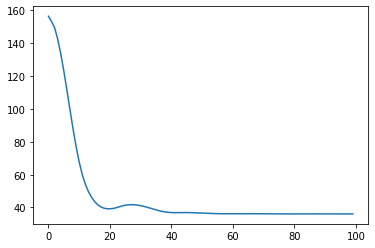

In [6]:
lower_bound = -np.sum(np.abs(weights + biases)) - N
vqe_input = tfq.convert_to_tensor([vqe.circuit])
vqe_output = tf.convert_to_tensor([[lower_bound]])
print('Before training : <H>={}'.format(model.predict(x=vqe_input)))
history = model.fit(x=vqe_input, y=vqe_output, batch_size=1, epochs=100,
                    verbose=0)
plt.plot(history.history['loss'])
print('After training : <H>={} >= {}'.format(model.predict(x=vqe_input),
                                             lower_bound))